# Electricity Demand

I found a [csvs of ontario's hourly electricity demand](http://reports.ieso.ca/public/Demand/). According to [this nytimes article](https://www.nytimes.com/interactive/2020/04/08/upshot/electricity-usage-predict-coronavirus-recession.html) electricity use is a quick updating proxy for how the economy is reacting.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import math
import pandas as pd

from collections import Counter
from datetime import date, datetime

%matplotlib inline
plt.rcParams['figure.figsize'] = (16,10)

### 2020 Data

The data seems to versions as `PUB_Demand_2020_vXX.csv` where XX is an increasing integer (day of publication).

TODO: Find out what this is and probe for the latest file matching this pattern

In [2]:
# The Date format is e.g. 2020-12-31 and the Hour format is 1..24
# Combine these together to make a date of the form "2020-12-31 01"
# and pass that through strptime to find the date

elec2020DF = pd.read_csv(
    'http://reports.ieso.ca/public/Demand/PUB_Demand_2020_v107.csv',
    skiprows=3,
    parse_dates={'ts': ['Date', 'Hour']},
    dtype = {
        'Hour': pd.Int64Dtype(),
    },
    date_parser = lambda date, hour : pd.datetime.strptime(f"{date} {hour-1:02}", '%Y-%m-%d %H'),
    index_col='ts'
)

elec2020DF.head()

# We will want to compare different years, so let's work with times
# relative to the start of the year
elec2020DF.index = elec2020DF.index - elec2020DF.index.min()

data_til = elec2020DF.index.max()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  if sys.path[0] == '':


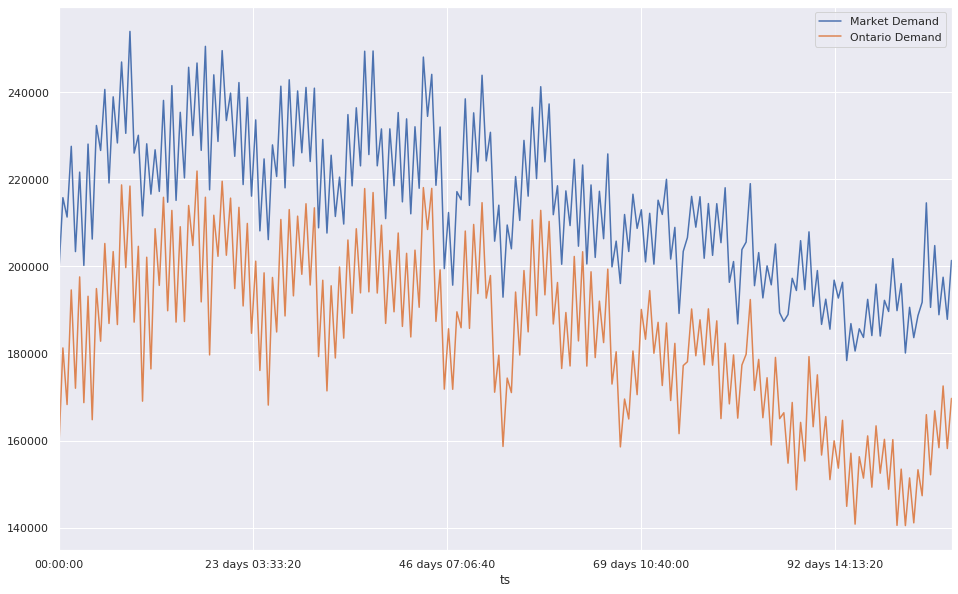

In [3]:
elec2020DF.resample('12h').sum().plot()

### 2019 Data

The filename schema seems to be the same as the 2020 data and the latest available seems to be `PUB_Demand_2019_v395.csv`

In [4]:
elec2019DF = pd.read_csv(
    'http://reports.ieso.ca/public/Demand/PUB_Demand_2019_v395.csv',
    skiprows=3,
    parse_dates={'ts': ['Date', 'Hour']},
    dtype = {
        'Hour': pd.Int64Dtype(),
    },
    date_parser = lambda date, hour : pd.datetime.strptime(f"{date} {hour-1:02}", '%Y-%m-%d %H'),
    index_col='ts'
)

# We will want to compare different years, so let's work with times
# relative to the start of the year
elec2019DF.index = elec2019DF.index - elec2019DF.index.min()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


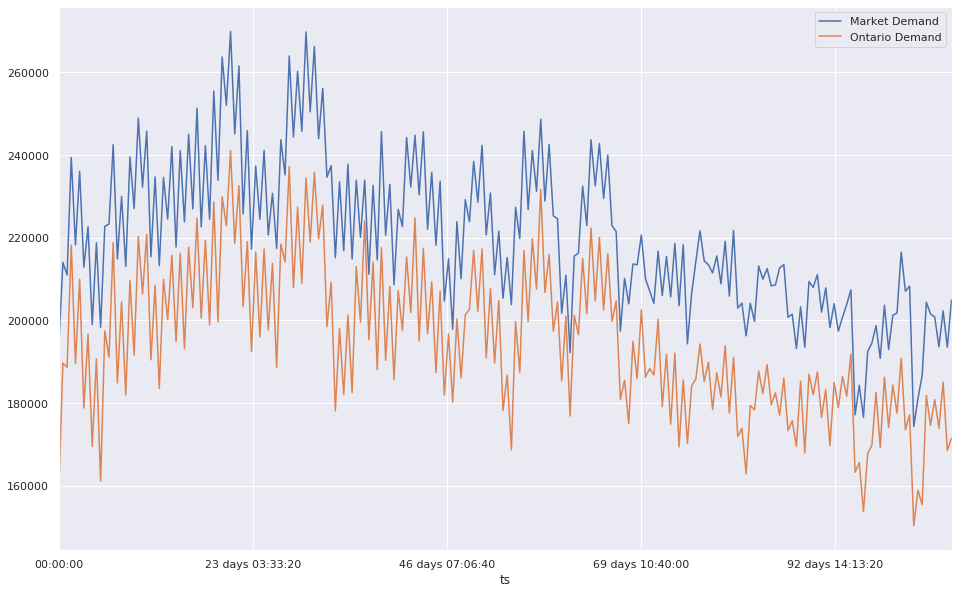

In [5]:
elec2019DF[:data_til].resample('12h').sum().plot()

Compare the rolling averages and see if there is a widening gap in March/April

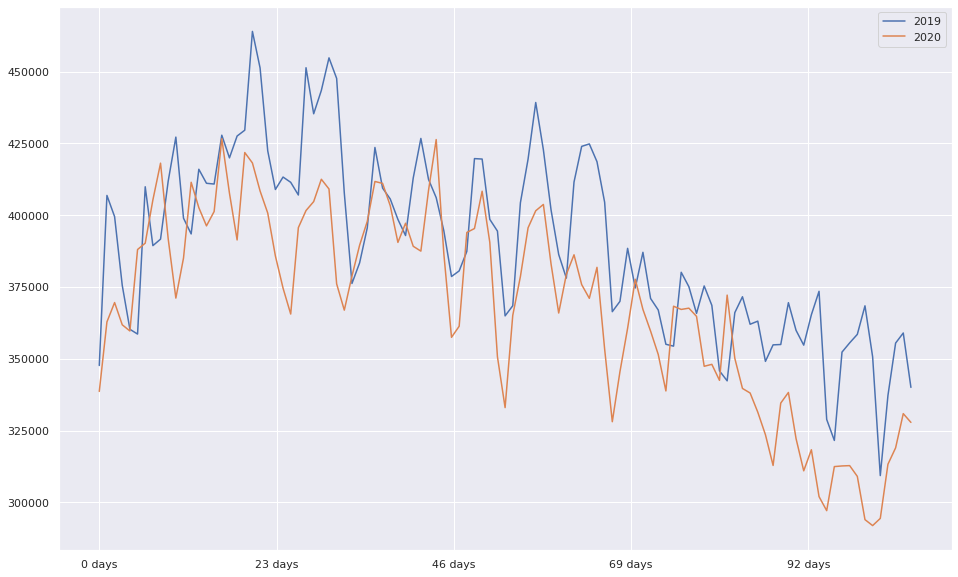

In [6]:
fig, ax = plt.subplots(1)

ax.plot(elec2019DF[:data_til]['Ontario Demand'].resample('24h').sum(), label='2019')
ax.plot(elec2020DF[:data_til]['Ontario Demand'].resample('24h').sum(), label='2020')
ax.legend()

# Timedelta.value reports nanoseconds so divide by number of ns in a day
formatter = ax.xaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, pos: f"{int(x/86400000000000)} days"))

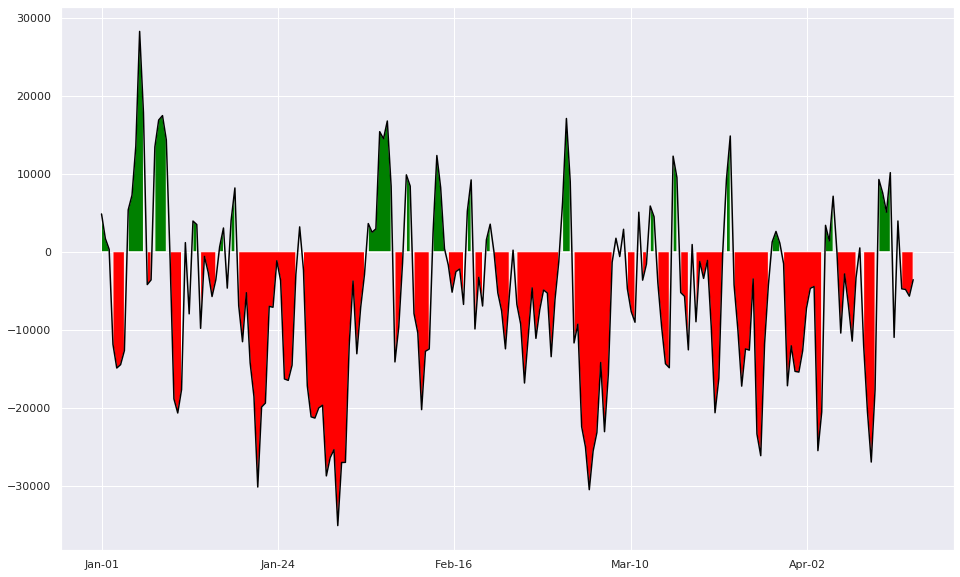

In [7]:
fig, ax = plt.subplots()

diff = elec2020DF[:data_til]['Market Demand'] - elec2019DF[:data_til]['Market Demand']
diff = diff.resample('12h').sum()
diff.index = diff.index.total_seconds()

ax.plot(diff, color='black')
ax.fill_between(diff.index, 0, diff.values, where=diff.values > 0, facecolor='green')
ax.fill_between(diff.index, 0, diff.values, where=diff.values < 0, facecolor='red')


# This is going to be very ugly, so forgive me, but I want to display the x
# axis as Jan, Feb, March etc. even though I just went to the trouble of
# making the axis be seconds since the start of the year
epoch2020 = int(datetime(2020,1,1,0,0).timestamp())
ax.xaxis.set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, pos: f"{pd.to_datetime(epoch2020 + x, unit='s').strftime('%b-%d')}"))